Keen readers of this blog (hi Mom!) might have noticed my recent focus on neural networks and deep learning. It's good for popularity, as deep learning posts are automatically cool ([I'm really big in China now](https://jiasuhui.com/article/3855)). Well, I'm going to leave the AI alone this time. In fact, this post won't even really constitute data science. Instead, I'm going to explore a topic that has been on my mind and maybe produce a few graphs.

These days, my main interaction with modern music is through the radio at the gym. It wasn't always like this. I mean [I used to be with it](https://www.youtube.com/watch?v=ajmI1P3r1w4), but then they changed what it was. I wouldn't go so far as to say that modern music is weird and scary, but it's certainly getting harder to keep up. It doesn't help that songs now have about 5 people on them. Back in my day, you might include a [brief rapper cameo to appear more edgy](http://www.youtube.com/watch?v=kfVsfOSbJY0&t=2m30s). So I thought I'd explore how song collaborations have come to dominate the charts. 

Note that the accompanying Jupyter notebook can be viewed [here](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-12-19-charting-the-rise-of-song-collaborations-with-scrapy-and-pandas.ipynb). Let's get started!

## Scrapy

In my research, I came across a similar [post](https://medium.com/fun-with-data-and-stats/visualizing-artist-collaborations-in-the-billboard-top-10-songs-ff6188a0f57b). That one looked at the top 10 of the Billboard charts going back to 1990. Just to be different, I'll primarily focus on the UK singles chart, though I'll also pull data from the Billboard chart. From what I can tell, there's no public API. But it's not too hard to scrape the data off [the official site](http://www.officialcharts.com/charts/singles-chart/). I'm going to use [Scrapy](https://scrapy.org/). We'll set up a spider to pull the relevant data and then navigate to the previous week's chart and repeat that process until it finally reaches the [first chart in November 1952](http://www.officialcharts.com/charts/singles-chart/19521114/7501/). This is actually the first time I've ever used Scrapy (hence the motivation for this post), so check out its extensive documentation if you have any issues. Scrapy isn't the only option for web scraping with Python (others reviewed [here](https://bigishdata.com/2017/06/06/web-scraping-with-python-part-two-library-overview-of-requests-urllib2-beautifulsoup-lxml-scrapy-and-more/), but I like how easy it is to [deploy and automate](https://doc.scrapy.org/en/latest/topics/deploy.html) your spiders for larger projects.

In [1]:
import scrapy
import re # for text parsing
import logging

class ChartSpider(scrapy.Spider):
    name = 'ukChartSpider'
    # page to scrape
    start_urls = ['http://www.officialcharts.com/charts/']
    # if you want to impose a delay between sucessive scrapes
#    download_delay = 0.5

    def parse(self, response):
        self.logger.info('Scraping page: %s', response.url)
        chart_week = re.sub(' -.*', '', 
                            response.css('.article-heading+ .article-date::text').extract_first().strip())
        
        for (artist, chart_pos, artist_num, track, label, lastweek, peak_pos, weeks_on_chart) in \
                             zip(response.css('#main .artist a::text').extract(),
                                 response.css('.position::text').extract(),
                                 response.css('#main .artist a::attr(href)').extract(),
                                 response.css('.track .title a::text').extract(),
                                 response.css('.label-cat .label::text').extract(),
                                 response.css('.last-week::text').extract(),
                                 response.css('td:nth-child(4)::text').extract(),
                                 response.css('td:nth-child(5)::text').extract()):
            yield {'chart_week': chart_week, 'chart_pos':chart_pos, 'track': track, 'artist': artist, 
                   'artist_num':re.sub('/.*', '', re.sub('/artist/', '', artist_num)), 
                   'label':label, 'last_week':re.findall('\d+|$', lastweek)[0],
                  'peak_pos':re.findall('\d+|$', peak_pos)[0], 
                   'weeks_on_chart':re.findall('\d+|$', weeks_on_chart)[0]}

# move onto next page (if it exists)             
        for next_page in response.css('.charts-header-panel:nth-child(1) .chart-date-directions'):
            if next_page.css("a::text").extract_first()=='prev':
                yield response.follow(next_page, self.parse)

In [2]:
import scrapy
import re # for text parsing
import logging

class ChartSpider(scrapy.Spider):
    name = 'usChartSpider'
    # page to scrape
    start_urls = ['https://www.billboard.com/charts/hot-100/']
    # if you want to impose a delay between sucessive scrapes
#   download_delay = 1.0 

    def parse(self, response):
        self.logger.info('Scraping page: %s', response.url)
        chart_week = response.xpath('.//time/@datetime').extract_first()
        
        for num, (artist, track, lastweek, peak_pos, weeks_on_chart) in \
            enumerate(zip(response.css('.chart-row__artist::text').extract(), 
                                 response.css('.chart-row__song::text').extract(),
                                 response.css('.chart-row__rank .chart-row__last-week::text').extract(),
                                 response.css('.chart-row__top-spot .chart-row__value::text').extract(),
                                 response.css('.chart-row__weeks-on-chart .chart-row__value::text').extract())):
            yield {'chart_week': chart_week, 'chart_pos':num+1, 'track': track, 'artist': artist.strip(), 
                   'last_week':re.findall('\d+|$', lastweek)[0],
                  'peak_pos':re.findall('\d+|$', peak_pos)[0], 
                   'weeks_on_chart':re.findall('\d+|$', weeks_on_chart)[0]}

# move onto next page (if it exists)             
        for next_page in response.css('.chart-nav__link'):
            if next_page.css('a::attr(title)').extract_first() == 'Previous Week':
                yield response.follow(next_page, self.parse)

Briefly explaining what happened there: We create a class called `ChartSpider`, essentially our customised spider (called `ukChartSpider`). We specify the page we want to scrape (`start_urls`). The spider then selects specific CSS elements (`response.css()`) within the page that contain the information we want (e.g. `#main .artist a` represents the artist's name). These tags may seem complicated, but they're actually quite easy to retrieve with a tool like [Selector Gadget](http://selectorgadget.com/). Isolate the elements you want to extract and copy the css elements highlighted with the tool (see image below).

![title](selector_gadget_.png)

Finally, we'll opt to write the spider output to a json file called `uk_charts.json`. Scrapy accepts [numerous file formats](https://doc.scrapy.org/en/latest/topics/feed-exports.html) (including CSV), but I went with JSON as it's easier to append to this file type, which may be useful if your spider unexpectedly terminates.  We're now ready to launch `ukChartSpider`. Note that the process for the US Billboard chart is very similar. That code can be found in the [accompanying Jupyter notebook](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-12-19-charting-the-rise-of-song-collaborations-with-scrapy-and-pandas.ipynb).

In [2]:
from scrapy.crawler import CrawlerProcess

process = CrawlerProcess({
'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)',
'FEED_FORMAT': 'json',
'FEED_URI': 'uk_charts.json'
})

# minimising the information presented on the scrapy log
logging.getLogger('scrapy').setLevel(logging.WARNING)
process.crawl(ChartSpider)
process.start()

2017-12-20 11:11:46 [scrapy.utils.log] INFO: Scrapy 1.4.0 started (bot: scrapybot)
2017-12-20 11:11:46 [scrapy.utils.log] INFO: Overridden settings: {'FEED_FORMAT': 'json', 'FEED_URI': 'uk_charts.json', 'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'}
2017-12-20 11:11:46 [ukChartSpider] INFO: Scraping page: http://www.officialcharts.com/charts/
2017-12-20 11:11:47 [ukChartSpider] INFO: Scraping page: http://www.officialcharts.com/charts/singles-chart/20171208/7501/
2017-12-20 11:11:48 [ukChartSpider] INFO: Scraping page: http://www.officialcharts.com/charts/singles-chart/20171201/7501/
2017-12-20 11:11:48 [ukChartSpider] INFO: Scraping page: http://www.officialcharts.com/charts/singles-chart/20171124/7501/


## Pandas

If that all went to plan, we can now load in the json file as pandas dataframe (unless you changed the file path, it should be sitting in your working directory). If you can't wait for the spider to conclude, then you can import the file directly from github (you can also find the corresponding Billboard Hot 100 file [there](https://github.com/dashee87/blogScripts/tree/master/files)- you might prefer downloading the files and importing them locally).

In [5]:
import pandas as pd
uk_charts = pd.read_json('https://raw.githubusercontent.com/dashee87/blogScripts/master/files/uk_charts.json')
# convert the date column to the correct date format
uk_charts = uk_charts.assign(chart_week=pd.to_datetime(uk_charts['chart_week']))
uk_charts.head(5)

,artist,artist_num,chart_pos,chart_week,label,last_week,peak_pos,track,weeks_on_chart
0,ED SHEERAN,6692,1,2017-12-08,ASYLUM,3,1,PERFECT,30
1,RAK-SU FT WYCLEF/NAUGHTY BOY,52716,2,2017-12-08,SYCO MUSIC,,2,DIMELO,1
2,RITA ORA,7418,3,2017-12-08,ATLANTIC,2,2,ANYWHERE,7
3,CAMILA CABELLO FT YOUNG THUG,51993,4,2017-12-08,EPIC/SYCO MUSIC,1,1,HAVANA,18
4,MARIAH CAREY,25943,5,2017-12-08,COLUMBIA,22,2,ALL I WANT FOR CHRISTMAS IS YOU,83


That table shows the top 5 singles in the UK for week starting 8st December 2017. I think I recognise two of those songs. As we're interested in collaborations, you'll notice that we have a few in this top 5 alone, which are marked with an 'FT' in the artist name. Unfortunately, there's [no consistent nomenclature to denote collaborations](https://music.stackexchange.com/questions/25532/whats-the-difference-between-feat-artist1-x-artist-2-artist1-vs-artist2) on the UK singles chart (the Billboard chart isn't as bad).

In [6]:
pd.concat((uk_charts[uk_charts['artist'].str.contains(' FEAT\\.')][0:1],
        uk_charts[uk_charts['artist'].str.contains(' FEATURING ')][0:1],
        uk_charts[uk_charts['artist'].str.contains(' FEAT ')][0:1],
        uk_charts[uk_charts['artist'].str.contains('/')][0:1],
        uk_charts[uk_charts['artist'].str.contains(' AND ')][0:1],
        uk_charts[uk_charts['artist'].str.contains(' & ')][0:1],
        uk_charts[uk_charts['artist'].str.contains(' WITH ')][0:1],
        uk_charts[uk_charts['artist'].str.contains(' VS ')][0:1],
        uk_charts[uk_charts['artist'].str.contains(' VS. ')][0:1]))

,artist,artist_num,chart_pos,chart_week,label,last_week,peak_pos,track,weeks_on_chart
128157,WEST END FEAT. SYBIL,41240,8,1993-02-14,PWL SANCTUARY,4,3,THE LOVE I LOST,6
98974,JODE FEATURING YO-HANS,7134,75,1998-12-20,LOGIC,48,48,WALK... (THE DOG) LIKE AN EGYPTIAN,2
89799,MUTINY FEAT D-EMPRESS,9653,100,2000-09-24,AZULI,,100,NEW HORIZONS,1
1,RAK-SU FT WYCLEF/NAUGHTY BOY,52716,2,2017-12-08,SYCO MUSIC,,2,DIMELO,1
69097,DJ SAMMY AND YANOU FT DO,3502,98,2004-09-12,DATA/MOS,100,1,HEAVEN,28
11,SELENA GOMEZ & MARSHMELLO,52496,12,2017-12-08,INTERSCOPE,9,9,WOLVES,6
31974,SOLDIERS WITH ROBIN GIBB,25894,75,2011-10-30,DMG TV,,75,I'VE GOTTA GET A MESSAGE TO YOU,1
4595,KUNGS VS COOKIN' ON 3 BURNERS,49557,96,2017-01-27,3 BEAT,90,2,THIS GIRL,33
98596,SLADE VS. FLUSH,5538,97,1999-01-17,POLYDOR,,30,MERRY XMAS EVERYBODY '98 REMIX,4


Okay, we've identified various terms that denote collaborations of some form. Not too bad. We just need to count the number of instances where the artist name includes one of these terms. Right? Maybe not.

In [7]:
pd.concat((uk_charts[uk_charts['artist'].str.contains('AC/DC')].tail(1),
uk_charts[uk_charts['artist'].str.contains('BOB MARLEY AND')].tail(1),
uk_charts[uk_charts['artist'].str.contains('BOB MARLEY &')].tail(1)))

,artist,artist_num,chart_pos,chart_week,label,last_week,peak_pos,track,weeks_on_chart
196512,AC/DC,16970,51,1978-06-04,ATLANTIC,,51,ROCK AND ROLL DAMNATION,1
129655,BOB MARLEY AND THE WAILERS,31532,5,1992-09-27,TUFF GONG,6,5,IRON LION ZION,3
203656,BOB MARLEY & THE WAILERS,31532,40,1975-09-21,ISLAND,,40,NO WOMAN NO CRY,1


I'm a firm believer that [domain expertise is a fundamental component of data science](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/), so good data scientists must always be mindful of AC/DC and Bob Marley. Obviously, these songs shouldn't be considered collaborations, so we need to exclude them from the analysis. Rather than manually evaluating each case, we'll discount artists that include  '&', 'AND', 'WITH', 'VS' that registered more than one song on the chart ('FT' and 'FEATURING' are pretty reliable- please let me know if I'm overlooking some brilliant 1980s post-punk new wave synth-pop group called 'THE FT FEATURING FT'). Obviously, we'll still have some one hit wonders mistaken as collaborations. For example, Derek and the Dominoes had only one hit single (Layla); though we're actually lucky in this instance, as the song was rereleased in 1982 under a slight different name.

In [8]:
uk_charts[(uk_charts['artist'].str.contains('DEREK AND THE DOMINOES')) &
           (uk_charts['weeks_on_chart']==1)]

,artist,artist_num,chart_pos,chart_week,label,last_week,peak_pos,track,weeks_on_chart
181904,DEREK AND THE DOMINOES,14664,68,1982-02-28,RSO,,68,LAYLA {1982},1
211792,DEREK AND THE DOMINOES,14664,25,1972-08-06,POLYDOR,,25,LAYLA,1


In [9]:
uk_charts = pd.merge(uk_charts,
         uk_charts.groupby('artist').track.nunique().reset_index().rename(
        columns={'track': 'one_hit'}).assign(one_hit = lambda x: x.one_hit==1)).sort_values(
        ['chart_week', 'chart_pos'], ascending=[0, 1]).reset_index(drop=True)
uk_charts.head()

,artist,artist_num,chart_pos,chart_week,label,last_week,peak_pos,track,weeks_on_chart,one_hit
0,ED SHEERAN,6692,1,2017-12-08,ASYLUM,3,1,PERFECT,30,False
1,RAK-SU FT WYCLEF/NAUGHTY BOY,52716,2,2017-12-08,SYCO MUSIC,,2,DIMELO,1,True
2,RITA ORA,7418,3,2017-12-08,ATLANTIC,2,2,ANYWHERE,7,False
3,CAMILA CABELLO FT YOUNG THUG,51993,4,2017-12-08,EPIC/SYCO MUSIC,1,1,HAVANA,18,True
4,MARIAH CAREY,25943,5,2017-12-08,COLUMBIA,22,2,ALL I WANT FOR CHRISTMAS IS YOU,83,False


In [10]:
# doing all the same stuff for the scraped Billboard chart data
us_charts =pd.read_json('https://raw.githubusercontent.com/dashee87/blogScripts/master/files/us_charts.json')
us_charts = us_charts.assign(chart_week=pd.to_datetime(us_charts['chart_week']))
us_charts['artist'] = us_charts['artist'].str.upper()
us_charts = pd.merge(us_charts,
         us_charts.groupby('artist').track.nunique().reset_index().rename(
        columns={'track': 'one_hit'}).assign(one_hit = lambda x: x.one_hit==1)).sort_values(
        ['chart_week', 'chart_pos'], ascending=[0, 1]).reset_index(drop=True)
us_charts.head()

,artist,chart_pos,chart_week,last_week,peak_pos,track,weeks_on_chart,one_hit
0,ED SHEERAN DUET WITH BEYONCE,1,2017-12-23,3,1,Perfect,15,True
1,POST MALONE FEATURING 21 SAVAGE,2,2017-12-23,1,1,Rockstar,12,True
2,CAMILA CABELLO FEATURING YOUNG THUG,3,2017-12-23,2,2,Havana,17,True
3,LIL PUMP,4,2017-12-23,4,3,Gucci Gang,13,True
4,IMAGINE DRAGONS,5,2017-12-23,5,4,Thunder,32,False


We've appended a column denoting whether that song represents that artist's only ever entry in the charts. We can use a few more tricks to weed out mislabelled collaborations. We'll ignore entries where the artist name contains 'AND THE' or '& THE'. Again, it's not perfect, but it should get us most of the way (data science in a nutshell). For example, 'Ariana Grande & The Weeknd' would be overlooked, so I'll crudely include a clause to allow The Weeknd related collaborations. With those caveats, let's plot the historical frequency of these various collaboration terms.

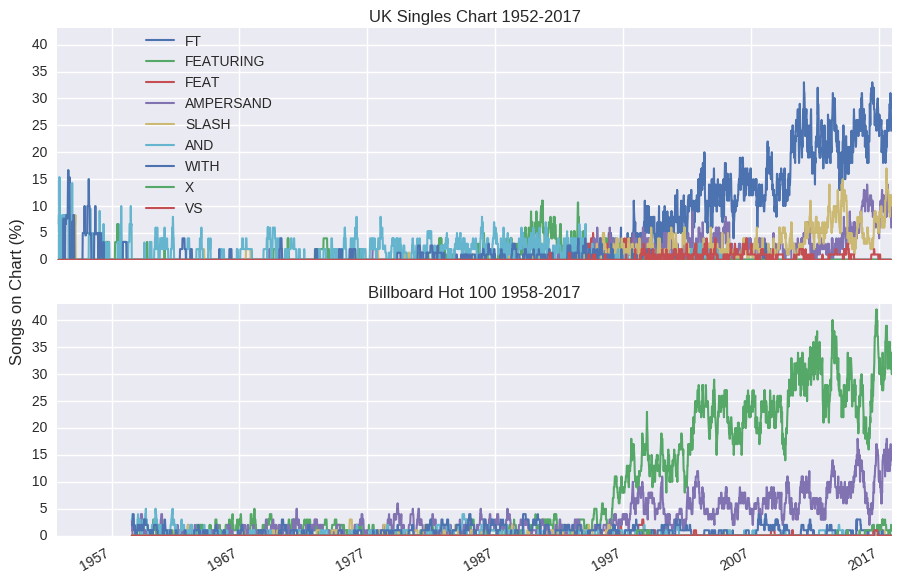

In [11]:
import seaborn
import matplotlib.pyplot as plt
import datetime

fig, (ax1, ax2) = plt.subplots(2,1)

# we're just going to do the same operation twice
# it's lazy; you could set up a loop or 
# combine the two dataframes into one (with a grouping column to tell which country it is)
uk_charts = uk_charts.assign(FT=((uk_charts['artist'].str.contains(' FT '))),
                 FEAT=((uk_charts['artist'].str.contains(' FEAT | FEAT\\. '))),
                 FEATURING=((uk_charts['artist'].str.contains(' FEATURING '))),
                 AND=((uk_charts['artist'].str.contains(' AND ')) &
                      ~(uk_charts['artist'].str.contains(' AND THE ') & ~uk_charts['artist'].str.contains(' THE WEEKND')) 
                           & (uk_charts['one_hit'])),
                AMPERSAND=((uk_charts['artist'].str.contains(' & ')) &
                      ~(uk_charts['artist'].str.contains(' & THE ') & ~uk_charts['artist'].str.contains(' THE WEEKND')) 
                           & (uk_charts['one_hit'])),
                SLASH=((uk_charts['artist'].str.contains('/')) & (uk_charts['one_hit'])),
                WITH=((uk_charts['artist'].str.contains(' WITH ')) & (uk_charts['one_hit'])),
                X=((uk_charts['artist'].str.contains(' X ')) & 
                   ~(uk_charts['artist'].str.contains('LIBERTY X|TWISTED X|MALCOLM X|RICHARD X|X MEN')) & 
                   (uk_charts['one_hit'])),
                VS=((uk_charts['artist'].str.contains(' VS | VS\\. ')) & (uk_charts['one_hit']))).assign(
    collab = lambda x: x.FT | x.FEATURING | x.AND | x.AMPERSAND | x.SLASH| x.WITH | x.VS| x.FEAT | x.X)

us_charts = us_charts.assign(FT=((us_charts['artist'].str.contains(' FT '))),
                 FEATURING=((us_charts['artist'].str.contains(' FEATURING '))),
                  FEAT=((us_charts['artist'].str.contains(' FEAT | FEAT\\. '))),
                 AND=((us_charts['artist'].str.contains(' AND ')) &
                      ~(us_charts['artist'].str.contains(' AND THE ') & ~us_charts['artist'].str.contains(' THE WEEKND')) 
                           & (us_charts['one_hit'])),
                AMPERSAND=((us_charts['artist'].str.contains(' & ')) &
                      ~(us_charts['artist'].str.contains(' & THE ') & ~us_charts['artist'].str.contains(' THE WEEKND')) 
                           & (us_charts['one_hit'])),
                SLASH=((us_charts['artist'].str.contains('/')) & (us_charts['one_hit'])),
                WITH=((us_charts['artist'].str.contains(' WITH ')) & (us_charts['one_hit'])),
                X=((us_charts['artist'].str.contains(' X ')) & 
                   ~(us_charts['artist'].str.contains('LIBERTY X|TWISTED X|MALCOLM X|RICHARD X|X MEN')) & 
                   (us_charts['one_hit'])),
                VS=((us_charts['artist'].str.contains(' VS | VS\\. ')) & (us_charts['one_hit']))).assign(
    collab = lambda x: x.FT | x.FEATURING | x.FEAT | x.AND | x.AMPERSAND | x.SLASH| x.WITH | x.VS | x.X)

uk_charts.groupby(['chart_week'])['FT','FEATURING', 'FEAT', 'AMPERSAND', 'SLASH', 'AND', 'WITH', 'X', 'VS'].mean().plot(
    linewidth=1.5, ax=ax1)
us_charts.groupby(['chart_week'])['FT','FEATURING', 'FEAT', 'AMPERSAND', 'SLASH', 'AND', 'WITH', 'X', 'VS'].mean().plot(
    linewidth=1.5, ax=ax2)
ax1.set_xticklabels('')
ax1.set_title('UK Singles Chart 1952-2017')
ax2.set_title('Billboard Hot 100 1958-2017')
for ax in [ax1, ax2]:
    ax.set_ylim([0, 0.43])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticklabels(['{:3.0f}'.format(x*100) for x in ax.get_yticks()])
    ax.set_xlim([datetime.date(1952,10,1), datetime.date(2018,1,1)])
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 10})
fig.text(0.0, 0.5,'Songs on Chart (%)', va='center', rotation='vertical',fontsize=12)
fig.set_size_inches(9, 6)
fig.tight_layout()
ax2.legend_.remove()
plt.show()

In the 1960s, 70s and 80s, colloborations were relatively rare (~5% of charted singles) and generally took the form of duets. Things changed in the mid 90s, when the number of colloborations increases significantly, with duets dying off and featured artists taking over. I blame rap music. Comparing the two charts, the UK and US prefer 'ft' and 'featuring', repsectively ([two nations divided by a common language](https://english.stackexchange.com/questions/74737/what-is-the-origin-of-the-phrase-two-nations-divided-by-a-common-language)). The Billboard chart doesn't seem to like the '/' notation, while the UK is generally much more eclectic. 

Finally, we can plot the proportion of songs that were collobarations (satisfied any of these conditions).

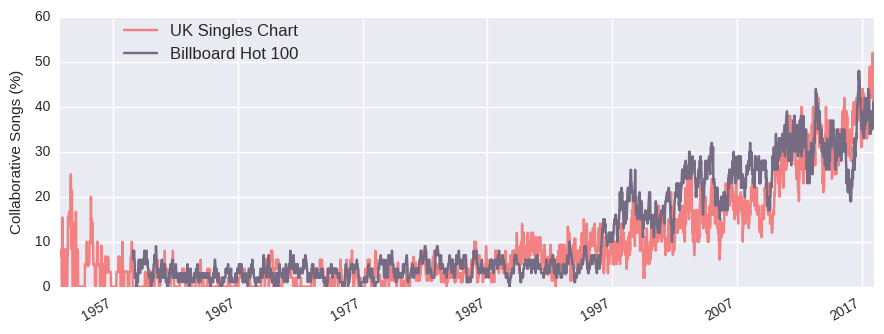

In [12]:
fig, ax1 = plt.subplots(1,1)
uk_charts.groupby(['chart_week'])['collab'].mean().plot(ax=ax1, color='#F38181')
us_charts.groupby(['chart_week'])['collab'].mean().plot(ax=ax1, color='#756C83')
ax1.set_xlabel('')
ax1.set_ylabel('Collaborative Songs (%)')
ax1.set_yticklabels(['{:3.0f}'.format(x*100) for x in ax1.get_yticks()])
ax1.set_xlim([datetime.date(1952,10,1), datetime.date(2018,1,1)])
fig.set_size_inches(9, 3.5)
ax1.legend(["UK Singles Chart", "Billboard Hot 100"], 
           bbox_to_anchor=(0.07, 1), loc=2, borderaxespad=0., prop={'size': 12})
fig.tight_layout()
plt.show()

Clearly, collaborations are on the rise in both the US and UK, with nearly half of all charted songs now constituting collaborations of some form. I should say the Billboard chart has always consisted of 100 songs (hence the name), while the UK chart originally had 12 songs (gradually increasing to 50 in 1960 and 75 in 1978, finally settling on 100 in 1994). That may explain why the UK records high percentages in 1950s, as it would only require several colloborations. 

Broadly speaking, the number of collaborations is pretty similar across the two countries. I suppose this isn't surprising, as famous artists are commonly popular in both countries. Between 1995 and 2005, the proportion of collaborations runs slightly higher on the Billboard chart. Without any rigorous analysis to validate my speculations, I put this down to rap music. This genre tends to have more featured artists and I suspect it took longer for it to achieve mainstream popularity in the UK. Nevertheless, there's no denying that collaborations are well on their way to chart domination.

## Summary

Using [Scrapy](https://scrapy.org/), we pulled historical data for both the [UK Singles Chart](http://www.officialcharts.com/charts/singles-chart/) and the [Billboard Hot 100](https://www.billboard.com/charts/hot-100). We converted it into a Pandas dataframe, which allowed us to manipulate the artist names to distinguish collaborations and highlight of popularity of various collaboration types. Finally, we've illustrated the recent surge in song collaborations, which now account for nearly half of all songs on the chart.

So, that's it. I apologise for the speculations and lack of cool machine learning. In my next post, I'll return to artificial intelligence to predict future duets between current and now deceased artists (e.g. 'Bob Marley & The Weeknd'). While you wait a very long time for that, you can download the historical UK chart and Billboard Top 100 files [here](https://github.com/dashee87/blogScripts/tree/master/files) or play around with the [accompanying Jupyter notebook](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-12-19-charting-the-rise-of-song-collaborations-with-scrapy-and-pandas.ipynb). Thanks for reading!